In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
data = pd.read_csv("US_Accidents_March23.csv")
data_dropped = data.dropna()
data_dropped['Start_Time'] = pd.to_datetime(data_dropped['Start_Time'], errors='coerce')
data_dropped['End_Time'] = pd.to_datetime(data_dropped['End_Time'], errors='coerce')
data_cleaned = data_dropped.drop(['Source'], axis=1)
data_cleaned.to_csv('preprocessed_data.csv', index=False)

In [ ]:
data = pd.read_csv("preprocessed_data.csv")
data.columns

In [ ]:
condition_map = {
    'Drizzle / Windy' : 'Drizzle',
    'Heavy Drizzle' : ' Drizzle',
    'Heavy Rain / Windy' : 'Heavy Rain',
    'Heavy Rain Shower' : 'Heavy Rain',
    'Heavy Rain Shower / Windy' : 'Heavy Rain',
    'Heavy Rain Showers' : 'Heavy Rain',
    'Heavy Snow / Windy' : 'Heavy Snow',
    'Heavy Snow with Thunder' : 'Heavy Snow',
    'Heavy T-Storm / Windy': 'Thunderstorms',
    'Heavy T-Storm': 'Thunderstorms',
    'Heavy Thunderstorms and Rain': 'Thunderstorms',
    'Heavy Thunderstorms and Rain' : 'Thunderstorms',
    'Heavy Thunderstorms and Snow' : 'Thunderstorms',
    'Heavy Thunderstorms with Small Hail' : 'Thunderstorms',
    'Light Blowing Snow': 'Light Snow',
    'Light Drizzle / Windy' :' Light Drizzle',
    'Light Rain / Windy' : 'Light Rain',
    'Light Rain Shower' : 'Light Rain',
    'Light Rain Shower / Windy' : 'Light Rain',
    'Light Rain Showers' : 'Light Rain',
    'Light Rain with Thunder' : 'Light Rain',
    'Light Sleet / Windy' :'Light Sleet',
    'Light Snow / Windy' : 'Light Snow',
    'Light Snow and Sleet' : 'Light Snow',
    'Light Snow Grains' : 'Light Snow',
    'Light Snow Shower' : 'Light Snow',
    'Light Thunderstorms and Rain' : 'Light Thunderstorms',
    'Light Thunderstorms and Snow' : 'Light Thunderstorms',
    'Rain / Windy' : 'Rain',
    'Rain Shower' : 'Rain', 
    'Rain Shower / Windy' : 'Rain',
    'Rain Showers' : 'Rain',
    'Snow / Windy' : 'Snow',
    'Snow and Sleet' : 'Snow',
    'Thunder' : 'Thunderstorms',
    'T-Storm' : ' Thunderstorms',
    'T-Storm / Windy' : ' Thunderstorms',
    'Thunder / Windy' : 'Thunderstorms',
    'Thunder in the Vicinity' : 'Thunderstorms',
    'Thunderstorms and Rain' : 'Thunderstorms',
    'Thunderstorms and Snow' : 'Thunderstorms',
    'Wintry Mix / Windy' : 'Wintry Mix',
    'Scattered Clouds' : 'Partly Cloudy',
    'Overcast' : 'Mostly Cloudy',
    'Light Drizzle': 'Light Rain',
    'Cloudy / Windy' : 'Windy',
    'Fair / Windy' : 'Windy',
    'Mostly Cloudy / Windy' : 'Windy',
    'Partly Cloudy / Windy' : 'Windy',
    'Fair' : 'Clear',
}

data2 = data
data2['Weather_Condition'].replace(condition_map, inplace=True)
data2.to_csv('fixed_conditions.csv', index=False)

In [2]:
data = pd.read_csv("fixed_conditions.csv")
data.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-3412645,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-3412650,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day
2,A-3412654,2,2016-02-08 11:51:46,2016-02-08 17:51:46,41.375310,-81.820170,41.367860,-81.821740,0.521,At Bagley Rd/Exit 235 - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day
3,A-3412656,2,2016-02-08 15:16:43,2016-02-08 21:16:43,40.109310,-82.968490,40.110780,-82.984000,0.826,At I-71/Exit 26 - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-3412657,2,2016-02-08 15:43:50,2016-02-08 21:43:50,39.192880,-84.477230,39.196150,-84.473350,0.307,At OH-4/Paddock Rd/Exit 9 - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day


In [3]:
data['Start_Time'] = pd.to_datetime(data["Start_Time"], errors = 'coerce').astype('int64')
data['End_Time'] = pd.to_datetime(data["End_Time"], errors = 'coerce').astype('int64')
data['Duration'] = (data.End_Time - data.Start_Time).div(10**9)
data = data.dropna()

In [4]:
# Feature selection (choose relevant columns)
selected_features = ["Start_Lat", "Start_Lng","End_Lat", "End_Lng", "Start_Time", "End_Time", "Duration", "Weather_Condition", #
                     "Timezone", "Turning_Loop", "No_Exit", "Crossing", "Junction", "Stop", "Traffic_Signal", "Severity"]

df = pd.get_dummies(data[selected_features], columns = [ "Timezone", "Weather_Condition"])
df.head()

,Start_Lat,Start_Lng,End_Lat,End_Lng,Start_Time,End_Time,Duration,Turning_Loop,No_Exit,Crossing,...,Weather_Condition_Thunder / Wintry Mix / Windy,Weather_Condition_Thunder and Hail,Weather_Condition_Thunder and Hail / Windy,Weather_Condition_Thunderstorm,Weather_Condition_Thunderstorms,Weather_Condition_Tornado,Weather_Condition_Widespread Dust,Weather_Condition_Widespread Dust / Windy,Weather_Condition_Windy,Weather_Condition_Wintry Mix
0,40.108910,-83.092860,40.112060,-83.031870,1454891828000000000,1454913428000000000,21600.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,39.172393,-84.492792,39.170476,-84.501798,1454918023000000000,1454939623000000000,21600.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,41.375310,-81.820170,41.367860,-81.821740,1454932306000000000,1454953906000000000,21600.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,40.109310,-82.968490,40.110780,-82.984000,1454944603000000000,1454966203000000000,21600.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,39.192880,-84.477230,39.196150,-84.473350,1454946230000000000,1454967830000000000,21600.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [5]:
# Append new rows to the dataframe with a severity of 3, whose values are inverted from those with 2 
df_2 = df[df['Severity'] == 2].copy()
df_2['Severity'] = 3
bool_cols = df_2.select_dtypes(include=[bool]).columns
df_2[bool_cols] = ~df_2[bool_cols]
df = pd.concat([df, df_2], ignore_index=True)
df['Severity'].value_counts()

Severity
3    3416471
2    3348445
4     112511
1      25567
Name: count, dtype: int64

In [6]:
df_4 = df[df['Severity'] == 4].copy()
df_4['Severity'] = 1
bool_cols = df_4.select_dtypes(include=[bool]).columns
df_4[bool_cols] = ~df_4[bool_cols]
df = pd.concat([df, df_4], ignore_index=True)
df['Severity'].value_counts()

Severity
3    3416471
2    3348445
1     138078
4     112511
Name: count, dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Severity']), df['Severity'], test_size=0.2, random_state=42)
# zero index y_train
y_train -= 1
y_test -= 1
X_test.head()

,Start_Lat,Start_Lng,End_Lat,End_Lng,Start_Time,End_Time,Duration,Turning_Loop,No_Exit,Crossing,...,Weather_Condition_Thunder / Wintry Mix / Windy,Weather_Condition_Thunder and Hail,Weather_Condition_Thunder and Hail / Windy,Weather_Condition_Thunderstorm,Weather_Condition_Thunderstorms,Weather_Condition_Tornado,Weather_Condition_Widespread Dust,Weather_Condition_Widespread Dust / Windy,Weather_Condition_Windy,Weather_Condition_Wintry Mix
1363392,28.357449,-81.495717,28.357611,-81.498265,-9223372036854775808,-9223372036854775808,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3107486,34.400833,-118.830556,34.400833,-118.830556,1589278200000000000,1589282601000000000,4401.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5218016,43.203570,-77.653851,43.204594,-77.658044,1639937280000000000,1639945640000000000,8360.0,True,True,True,...,True,True,True,True,True,True,True,True,True,True
6560472,39.943590,-83.141930,39.943590,-83.141930,1588938593000000000,1588940393000000000,1800.0,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4139399,41.686903,-88.064293,41.701653,-88.035763,1672324727000000000,1672327513000000000,2786.0,True,True,True,...,True,True,True,True,True,True,True,True,False,True


In [8]:
bst = XGBClassifier(n_estimators=10, max_depth=3, learning_rate=1, objective='multi:softmax')
bst.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

In [2]:
all_weather_conditions,all_timezones,ordering = pickle.load(open('One-Hot-Encoded_features_and_Ordering.pkl', 'rb'))
bst = pickle.load(open('xgboost_model.pkl','rb'))

[13:57:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



In [9]:
y_pred = bst.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9570736532865417

In [10]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_train.head()

,Start_Lat,Start_Lng,End_Lat,End_Lng,Start_Time,End_Time,Duration,Turning_Loop,No_Exit,Crossing,...,Weather_Condition_Thunder / Wintry Mix / Windy,Weather_Condition_Thunder and Hail,Weather_Condition_Thunder and Hail / Windy,Weather_Condition_Thunderstorm,Weather_Condition_Thunderstorms,Weather_Condition_Tornado,Weather_Condition_Widespread Dust,Weather_Condition_Widespread Dust / Windy,Weather_Condition_Windy,Weather_Condition_Wintry Mix
0,29.156098,-82.134349,29.157655,-82.129954,1605794370000000000,1605844956000000000,50586.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,40.280126,-74.084871,40.278575,-74.083710,-9223372036854775808,-9223372036854775808,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,41.144200,-95.938378,41.150413,-95.938615,1636564050000000000,1636566390000000000,2340.0,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,29.790718,-95.395891,29.790723,-95.395477,1608092741000000000,1608099761000000000,7020.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,39.058536,-122.586217,39.059502,-122.586044,1601412240000000000,1601425648000000000,13408.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
The figure layout has changed to tight
The figure layout has changed to tight


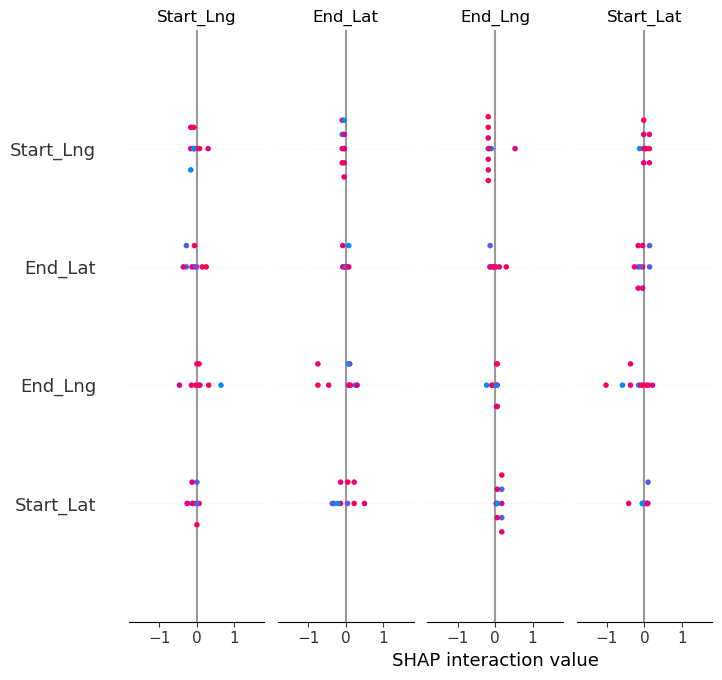

In [11]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer(X_train[0:10]) 
shap.summary_plot(shap_values, X_test[0:10], feature_names=df.drop(columns=["Severity"]).columns, plot_size=(1, 20))

In [12]:
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(bst, file)

In [2]:
# Example new datapoint (replace with your actual data)
all_weather_conditions,all_timezones,ordering = pickle.load(open('One-Hot-Encoded_features_and_Ordering.pkl', 'rb'))
bst = pickle.load(open('xgboost_model.pkl','rb'))
raw_data = {
    "Start_Lat": 47.123,
    "Start_Lng": -122.456,
    "End_Lat": 47.789,
    "End_Lng": -122.987,
    "Start_Time": "2024-04-11T10:00:00",
    "End_Time": "2024-04-11T11:30:00",
    "Weather_Condition": "Clear",
    "Timezone": "US/Pacific",
    "Turning_Loop": False,
    "No_Exit": True,
    "Crossing": False,
    "Junction": True,
    "Stop": False,
    "Traffic_Signal": True
}

datapoint = pd.DataFrame([raw_data])

# Convert start and end times to pandas datetime objects
datapoint["Start_Time"] = pd.to_datetime(datapoint["Start_Time"], errors="coerce").astype("int64")
datapoint["End_Time"] = pd.to_datetime(datapoint["End_Time"], errors="coerce").astype("int64")

# Calculate duration
datapoint["Duration"] = (datapoint["End_Time"] - datapoint["Start_Time"]).div(10**9)

# Create one-hot-encoded columns for weather conditions
for condition in all_weather_conditions:
    datapoint["Weather_Condition_"+condition] = (datapoint["Weather_Condition"] == condition).astype(int)

# Create one-hot-encoded columns for timezones
for timezone in all_timezones:
    datapoint["Timezone_"+timezone] = (datapoint["Timezone"] == timezone).astype(int)

# Drop original columns
datapoint.drop(columns=["Weather_Condition", "Timezone"], inplace=True)
datapoint = datapoint[ordering]

In [3]:
predicted_result = bst.predict_proba(datapoint)
print(predicted_result)

[[8.7157160e-04 9.8914528e-01 1.4857064e-03 8.4973145e-03]]


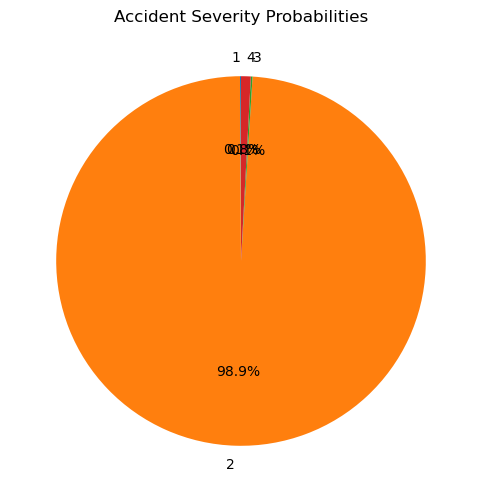

In [6]:
import matplotlib.pyplot as plt

# Example class labels (replace with your actual class labels)
class_labels = [i+1 for i in range(len(predicted_result[0]))]

# Create a pie chart
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.pie(predicted_result[0], labels=class_labels, autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Accident Severity Probabilities')

# Show the pie chart
plt.show()